<a href="https://colab.research.google.com/github/KwonHo-geun/AI_Study/blob/main/25.07.31_DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision import transforms as T
from matplotlib import pyplot as plt
from torch import nn
from tqdm.auto import tqdm
import torchvision.utils as vutils

transform = T.Compose([T.Resize(32),
                      T.ToTensor(),
                      T.Normalize((0.5), (0.5))]) # ==> image normalize range = [-1,1] 으로 수정한 부분입니다.
dataset = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transform
)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)


100%|██████████| 26.4M/26.4M [00:02<00:00, 11.1MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 200kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.73MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 21.6MB/s]


In [2]:
num_epochs = 3
num_workers = 2
batch_size = 128
nz = 100  # Size of z latent vector (i.e. size of generator input)
ngf = 64  # Size of feature maps in generator
ndf = 64  # Size of feature maps in discriminator

# Spatial size of training images. All images will be resized to this
#   size using transforms.
image_size = 32

# Number of channels in the training images. For color images this is 3
nc = 1

device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
print(device)

cuda:0


  0%|          | 0/938 [00:00<?, ?it/s]

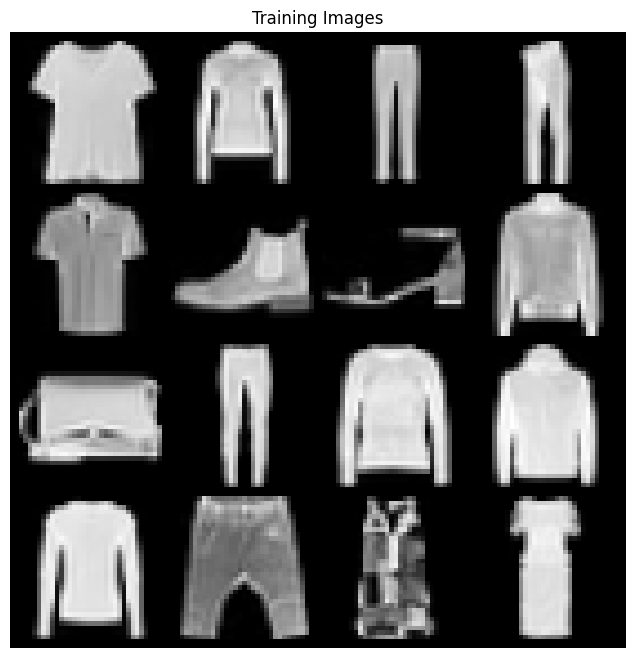

In [3]:
for i, (image, _) in enumerate(tqdm(dataloader)): # image 의 label은 쓰지 않아서 _ 처리 했다.
  # Plot some training images
  plt.figure(figsize=(8,8))
  plt.axis("off")
  plt.title("Training Images")
  plt.imshow(vutils.make_grid(image[:16], padding=2, normalize=True, nrow=4).permute(1,2,0)) # (4,4)로 만들어줌.
  break

In [4]:
print(image.min(), image.max()) # --> normalized image range 가 수정되었습니다

tensor(-1.) tensor(0.9922)


In [5]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 4, 4, 1, 0, bias=False), # ngf 에 따라 채널 수를 결정한다.
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. 4 x 4
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. 8 x 8
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. 16 x 16
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 32 x 32
        )

    def forward(self, input):
        return self.main(input)

netG = Generator().to(device)
print(netG)


Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)


In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.ModuleList([
            # input is (nc) x 32 x 32
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 16 x 16
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 8 x 8
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 4 x 4
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        ])

    def forward(self, x):
        for layer in self.main:
          x = layer(x)
        return x

netD = Discriminator().to(device)
print(netD)


Discriminator(
  (main): ModuleList(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (9): Sigmoid()
  )
)


In [7]:
# Initialize BCELoss function
criterion = nn.BCELoss() #Binary Cross Entropy Loss - 이진분류 손실함수

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
#그렇기에  예측값과 타깃값이 float type의 0 ~ 1의 실수 값이라 생각해야함.
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = torch.optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [8]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")


# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, (image, _) in enumerate(tqdm(dataloader)):
        image = image.to(device)
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        bs = image.size(0)
        label = torch.full((bs,), real_label, dtype=torch.float, device=device)
        output = netD(image).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()

        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(bs, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)

        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)

        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)

        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)

        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 100 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...


  0%|          | 0/938 [00:00<?, ?it/s]

[0/3][0/938]	Loss_D: 1.4664	Loss_G: 1.1705	D(x): 0.5723	D(G(z)): 0.5859 / 0.3183
[0/3][50/938]	Loss_D: 0.0344	Loss_G: 5.4183	D(x): 0.9851	D(G(z)): 0.0180 / 0.0049
[0/3][100/938]	Loss_D: 7.0596	Loss_G: 7.9575	D(x): 0.0040	D(G(z)): 0.0000 / 0.0017
[0/3][150/938]	Loss_D: 0.5031	Loss_G: 3.7979	D(x): 0.8911	D(G(z)): 0.2851 / 0.0286
[0/3][200/938]	Loss_D: 0.3115	Loss_G: 2.3854	D(x): 0.8202	D(G(z)): 0.0936 / 0.1045
[0/3][250/938]	Loss_D: 0.5529	Loss_G: 2.7112	D(x): 0.6260	D(G(z)): 0.0228 / 0.0901
[0/3][300/938]	Loss_D: 0.3473	Loss_G: 2.9476	D(x): 0.8900	D(G(z)): 0.1906 / 0.0659
[0/3][350/938]	Loss_D: 0.5412	Loss_G: 1.9822	D(x): 0.7557	D(G(z)): 0.2059 / 0.1530
[0/3][400/938]	Loss_D: 0.5104	Loss_G: 1.4494	D(x): 0.6991	D(G(z)): 0.0981 / 0.2745
[0/3][450/938]	Loss_D: 0.9148	Loss_G: 5.2473	D(x): 0.9560	D(G(z)): 0.5375 / 0.0098
[0/3][500/938]	Loss_D: 0.4968	Loss_G: 4.0723	D(x): 0.9388	D(G(z)): 0.3278 / 0.0242
[0/3][550/938]	Loss_D: 0.8634	Loss_G: 3.5148	D(x): 0.9585	D(G(z)): 0.5214 / 0.0397
[0/3][6

  0%|          | 0/938 [00:00<?, ?it/s]

[1/3][0/938]	Loss_D: 0.4590	Loss_G: 1.8944	D(x): 0.8306	D(G(z)): 0.2119 / 0.1803
[1/3][50/938]	Loss_D: 0.6011	Loss_G: 1.6449	D(x): 0.6835	D(G(z)): 0.1650 / 0.2199
[1/3][100/938]	Loss_D: 0.4786	Loss_G: 2.4711	D(x): 0.7543	D(G(z)): 0.1529 / 0.1056
[1/3][150/938]	Loss_D: 0.6572	Loss_G: 2.9928	D(x): 0.9597	D(G(z)): 0.4153 / 0.0632
[1/3][200/938]	Loss_D: 0.5150	Loss_G: 1.6258	D(x): 0.8646	D(G(z)): 0.2738 / 0.2303
[1/3][250/938]	Loss_D: 1.4478	Loss_G: 6.4180	D(x): 0.9695	D(G(z)): 0.7189 / 0.0028
[1/3][300/938]	Loss_D: 0.2513	Loss_G: 2.7931	D(x): 0.8735	D(G(z)): 0.0995 / 0.0711
[1/3][350/938]	Loss_D: 0.6917	Loss_G: 2.2832	D(x): 0.8811	D(G(z)): 0.3803 / 0.1256
[1/3][400/938]	Loss_D: 0.2891	Loss_G: 2.6757	D(x): 0.9107	D(G(z)): 0.1653 / 0.0856
[1/3][450/938]	Loss_D: 0.4116	Loss_G: 2.1837	D(x): 0.8279	D(G(z)): 0.1851 / 0.1303
[1/3][500/938]	Loss_D: 1.5781	Loss_G: 0.5419	D(x): 0.2700	D(G(z)): 0.0514 / 0.6175
[1/3][550/938]	Loss_D: 0.4836	Loss_G: 4.0310	D(x): 0.9430	D(G(z)): 0.3226 / 0.0224
[1/3][6

  0%|          | 0/938 [00:00<?, ?it/s]

[2/3][0/938]	Loss_D: 0.0922	Loss_G: 3.3461	D(x): 0.9560	D(G(z)): 0.0444 / 0.0509
[2/3][50/938]	Loss_D: 0.0731	Loss_G: 4.4336	D(x): 0.9444	D(G(z)): 0.0140 / 0.0157
[2/3][100/938]	Loss_D: 0.1422	Loss_G: 3.7777	D(x): 0.8922	D(G(z)): 0.0239 / 0.0297
[2/3][150/938]	Loss_D: 0.0702	Loss_G: 5.2246	D(x): 0.9400	D(G(z)): 0.0072 / 0.0071
[2/3][200/938]	Loss_D: 0.0575	Loss_G: 4.0919	D(x): 0.9638	D(G(z)): 0.0196 / 0.0227
[2/3][250/938]	Loss_D: 0.0837	Loss_G: 3.8555	D(x): 0.9780	D(G(z)): 0.0583 / 0.0268
[2/3][300/938]	Loss_D: 0.1268	Loss_G: 4.0375	D(x): 0.9863	D(G(z)): 0.1033 / 0.0220
[2/3][350/938]	Loss_D: 0.0345	Loss_G: 4.5754	D(x): 0.9853	D(G(z)): 0.0193 / 0.0138
[2/3][400/938]	Loss_D: 1.0209	Loss_G: 1.5834	D(x): 0.4647	D(G(z)): 0.0305 / 0.2704
[2/3][450/938]	Loss_D: 0.1134	Loss_G: 3.5457	D(x): 0.9438	D(G(z)): 0.0520 / 0.0378
[2/3][500/938]	Loss_D: 0.0487	Loss_G: 3.9094	D(x): 0.9776	D(G(z)): 0.0252 / 0.0317
[2/3][550/938]	Loss_D: 0.0305	Loss_G: 5.1610	D(x): 0.9771	D(G(z)): 0.0071 / 0.0081
[2/3][6

In [ ]:
import matplotlib.animation as animation
from IPython.display import HTML

fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(i.permute(1,2,0), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())